### Run of the ABM

In this file we are going to run a simple version of the model from HSC to CLP and their descendant. We consider one type of MPP, and that this MPP as two possible descendants, CMP or CLP, the latter give birth to Dendritic_cell, NK, B_Cell, T_Cell.

We set the paremeters for HSC, ST-HSC, MPP with the data of the paper: **Fundamental properties of unperturbed haematopoiesis from stem cells in vivo**

*On average, per day, 1 out of 110 HSCs differentiates into an ST-HSC, and 1 out of 22 ST-HSCs differentiates into an MPP. At the MPP stage, considered a lymphoid–myeloid bifurcation point, we estimate that per day 1 out of 46 MPPs generates a CLP, while 1 MPP generates 4 CMPs. Given that the cell numbers also increase from HSC to ST-HSC and MPP, the efflux of cells exceeded influx in all of these compartments. To maintain compartment size, this flux difference is balanced by net proliferation.*

We try to set the parameters of B_cell, CLP and more global parameters using **Hematopoeisis in number**:

- Total number of hematopoeitic cell in a mouse = $1.7 * 10^10$ ( $1.6 * 10^10$ in blood, $4.5 * 10^8$ in bone marrow, $2.1 * 10^8$ in thymus, $7.6 * 10^7$ in lymph node, $2.1 * 10^8$ in the spleen)
- Total cell number across different compartment in a healthy mice: $10^4$ HSC, $10^5$ MPP, $10^6$ RPP, $10^8$ Granulomyeloids, $10^9$ Platelets, $10^10$ Erythrocytes, $10^8$ Lymphoids

Information found in supplementary material 1:

Definition of the information given in the paper:
- **Lifespan** = 1/Death rate = t1/2/ln(2)
- **Half life** = time for half to die 

Cell type parameters (Lifespan/ death rate):

- B Cell: Half-life = 24,3 days, lifespan = 35,00 days, death_rate = 0.03
- Granulomyeloids: half-life = 0.84, lifespan = 1.21 days, death_rate = 0.83
- Platelets: Half-life = 2.5 days, lifespan = 3.60 days, death_rate = 0.28
- Red blood cells: half-life = 24.3 days, lifespan = 35 days, death_rate = 0.03


We initialize different struct of our model TypeParameters, transition_matrix_0, TransitionDistribution.

- TypeParameters: 2 parmeters "time to death" (ttd) and "time to next division" (ttnd). They have the form of a vector of tuple of Float. Each tuple corresponds to the parameters of a cell type. The first float in each tuple is the mean ttd ot ttnd in number of days and the second float in each tuple is the standart deviation. We will draw ttd and ttnd for cell given distribution whith these parameters. 

- transition_matrix_0: This initialize a transition matrix. It is a squared matrix of size the number of cell type. The first row corresponds to the first cell type. transition_matrix_0[1,2] is the probability per day for a cell of type 1 to transition to type 2. transition_matrix_0[1,1] corresponds to the probability for a cell of type 1 to stay in type 1 per day. 

- TransitionDistribution: 1 parameter "time to next transition"(ttnt). It is a vector of vector. Each vector correspond to the distribution of transition time for each type. This distribution is of variable length and corresponds to the cdf of a geometric distribution, but the "times" step are 0.001. From these we can draw a random number between 0 and 1 and then we look for the first index at hich this random number is superior to, we divide this index by 1000 and get the time at which transition will occur.

In [1]:
Base.@kwdef struct TypeParameters
    # each of the properties has for length the number of type
    ttd::Vector{Tuple} = [(10000.0, 0.18), (330.0, 80.0), (70.0, 20), (60.0, 30), (1.1, 0.5)] #Time to death
    ttnd::Vector{Tuple} = [(110, 0.1), (1/0.042, 0.2), (0.25, 0.1), (86.66, 0.18), (10.9, 0.23)] # Time to next division
end

Base.@kwdef struct TransitionDistribution
    
    ttnt::Vector{Vector{Float64}} = []
end


TransitionDistribution

In [2]:
#From data of supplemental material of Fundamental properties of unperturbed haematopoiesis from stem cells in vivo
#if we know n_HSC we can define relative compartment size. 
n_HSC = 1.0
n_STHSC = 2.9
n_MPP = 9.0
n_CMP = 39.0
n_CLP = 13.0

#Differentiation rate:
a_HSC_STHSC = 0.009
a_STHSC_MPP = 0.045
a_MPP_CMP = 3.992
a_MPP_CLP = 0.022

# Transition Matrix = [HSC, ST-HSC, MPP, CLP, CMP, ; ]

transition_matrix_0 = [(1 - a_HSC_STHSC/n_HSC) (a_HSC_STHSC/n_HSC) 0.0 0.0 0.0 ;   #HSC
                      0.0 (1 - a_STHSC_MPP/n_STHSC) (a_STHSC_MPP/n_STHSC) 0.0 0.0 ;       #ST-HSC
                      0.0 0.0 (1 - a_MPP_CLP/n_MPP - a_MPP_CMP/n_MPP) a_MPP_CLP/n_MPP a_MPP_CMP/n_MPP ;  #MPP
                      0.0 0.0 0.0 1.0 0.0 ;  #CLP
                      0.0 0.0 0.0 0.0 1.0 ;          #CMP
                      ]        

#residence time estimation: MPP 70 days, CLP 60 days (time spend in this differentiation state left by death or transition)

5×5 Matrix{Float64}:
 0.991  0.009     0.0        0.0         0.0
 0.0    0.984483  0.0155172  0.0         0.0
 0.0    0.0       0.554      0.00244444  0.443556
 0.0    0.0       0.0        1.0         0.0
 0.0    0.0       0.0        0.0         1.0

We initialize TypeParameters, TransitionDistribution for the model, here we use the default values of those stuct.

**n_tot** corresponds to the total number of cell at time 0.

**collection_t0** corresponds to number of cell and their type at time 0, of the form [(type, number of cell of this type), ...]

In [7]:
include("Initialization.jl")

typeparameters_0 = TypeParameters()

TypeParameters(Tuple[(10000.0, 0.18), (330.0, 80.0), (70.0, 20), (60.0, 30), (1.1, 0.5)], Tuple[(110, 0.1), (23.809523809523807, 0.2), (0.25, 0.1), (86.66, 0.18), (10.9, 0.23)])

In [16]:
transition_distribution_0 = TransitionDistribution([
transition_time_distribution(transition_matrix_0[1,:], 1),
transition_time_distribution(transition_matrix_0[2,:], 2),
transition_time_distribution(transition_matrix_0[3,:], 3),
transition_time_distribution(transition_matrix_0[4,:], 4),
transition_time_distribution(transition_matrix_0[5,:], 5)])
n_states = length(typeparameters_0.ttd)



5

In [17]:
n_tot = 39
collection_t0 = [(1,10), (2,29)]

2-element Vector{Tuple{Int64, Int64}}:
 (1, 10)
 (2, 29)

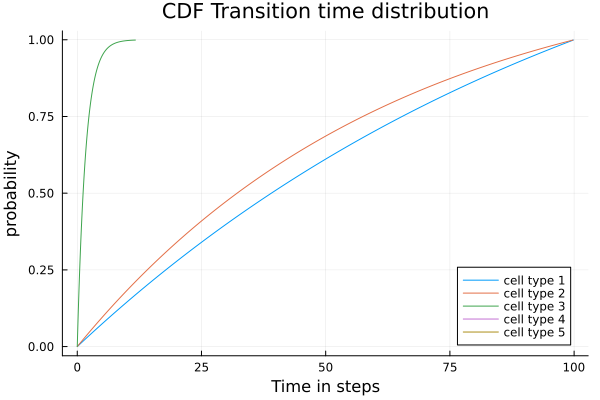

In [22]:
using Plots

length(transition_distribution_0.ttnt[1])
plot((1:length(transition_distribution_0.ttnt[1]))./1000,transition_distribution_0.ttnt[1], label= "cell type 1", show = true, title ="CDF Transition time distribution", xlabel="Time in steps", ylabel = "probability")
plot!((1:length(transition_distribution_0.ttnt[2]))./1000,transition_distribution_0.ttnt[2], label= "cell type 2", show = true)
plot!((1:length(transition_distribution_0.ttnt[3]))./1000,transition_distribution_0.ttnt[3], label= "cell type 3", show = true)
plot!((1:length(transition_distribution_0.ttnt[4]))./1000,transition_distribution_0.ttnt[4], label= "cell type 4", show = true)
plot!((1:length(transition_distribution_0.ttnt[5]))./1000,transition_distribution_0.ttnt[5], label= "cell type 5", show = true)

type_distribution_0 is a vector of vector, with one vector for each type and in each of these 2 distribution. The first distribution corresponds to the time to death and the second to the time to next division. We will draw from these distribution to attribute each cell a ttd and ttnd. It is possible to modify type_distribution when we run the model.

cell_collection_0 is a Vector of Vector, one vector corresponds to a cell. Each cell is attributed a type, ttd, ttnd, ttnt, as such [type, ttd, ttnd, ttnt]. This object is created based on collection_t0 and the dsitributions of ttd, ttnd, ttnt established above. 

In [23]:
type_distribution_0 = initialize_distributions(typeparameters_0, n_states)

cell_collection_0 = initialize_collection(type_distribution_0, transition_distribution_0.ttnt, collection_t0, n_tot)

39-element Vector{Vector{Any}}:
 [1, 9025.184776985492, 98.35359949711531, 25.223]
 [1, 8449.011678832427, 108.82602803829815, 61.127]
 [1, 9024.432295133269, 127.82498257669609, 23.372]
 [1, 10373.131987154022, 114.37265114983401, 60.552]
 [1, 10553.118713640191, 114.12581938401928, 56.575]
 [1, 7322.948352226361, 107.80405597623978, 99.42]
 [1, 9099.839494447966, 113.20511771587485, 49.774]
 [1, 8762.69550872966, 116.67203724454566, 28.005]
 [1, 11151.68770020366, 103.85454067698312, 1.976]
 [1, 10956.5264320367, 119.81201355911553, 6.489]
 ⋮
 [2, 0.0, 24.80513841698972, 79.326]
 [2, 0.0, 23.355715911339967, 6.381]
 [2, 0.0, 18.299716353002417, 92.58]
 [2, 0.0, 22.679811637635755, 40.093]
 [2, 0.0, 25.65145153431986, 40.522]
 [2, 0.0, 30.276508844233003, 42.64]
 [2, 0.0, 21.786630158996562, 75.198]
 [2, 0.0, 23.405666323760922, 76.463]
 [2, 0.0, 21.76466551859989, 87.619]

The following cell must be modified, rerun for each run of the model, to avoid overwriting data, and to reinitilize
death_file defines the location and name of the txt file where 

In [42]:
death_file = "C:\\Users\\ambre\\Documents\\ENS\\stage_M1\\code_1\\test_file"
modelparameters_0 = initialize_modelparameters(9, death_file, transition_matrix_0, typeparameters_0, transition_distribution_0)

life = initialize_model(collection_t0, transition_distribution_0, modelparameters_0, typeparameters_0, n_tot, ms)

StandardABM with 39 agents of type HematopoeiticCell
 space: nothing (no spatial structure)
 scheduler: ms
 properties: s, n_steps, activation_rate, adata, deaths, nbr_state, death_file, matrix, pool, ttnd_parameters, ttnt_parameters, ttd_parameters, var_ttnd, var_ttnt, var_ttd

In [43]:
custom_run!(life, life_step!, model_step!, n)
life.s

2000

In [49]:
life[228900]

HematopoeiticCell(228900, 1, 7957.0491743023495, 2010.121497103766, 9.999999983275812e6, "Division", 2010.121497103766, 17, [5, 121, 1, 40, 245, 1, 44, 334, 1, 49  …  1, 28101, 1667, 1, 56083, 1780, 1, 114736, 1890, 1])

What to do know?

- verifier si fonctionne quand temps inférieur au jour: oui ça fonctionne ! 
- recommenter les fonctions 
- tester modele sur long temps
- tracer populations en fonction du temps
- relire article modelo niche
- écrire le notebook
- trouver package pour dessiner des arbres temporellement coherent. 
- faire en sorte que les paramètres du modèles soit enregistrer dans un fichier, aussi enregistrer si les paramètres sont modifier pendant la simu! pas seuleemnt au début. 
- stocker les données final, plot, numbers, dans un fichier. 